In [18]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import matplotlib.dates as mandates

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error, r2_score
from sklearn import metrics
from sklearn import linear_model

from keras.layers import LSTM, Dense, Dropout
from keras.models import Sequential

In [19]:
data = pd.read_csv('Google_Historical_StockPrice2.csv')
data.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2016-03-28,736.789978,738.989990,732.500000,733.530029,733.530029,1301300
1,2016-03-29,734.590027,747.250000,728.760010,744.770020,744.770020,1903800
2,2016-03-30,750.099976,757.880005,748.739990,750.530029,750.530029,1782400
3,2016-03-31,749.250000,750.849976,740.940002,744.950012,744.950012,1718800
4,2016-04-01,738.599976,750.340027,737.000000,749.909973,749.909973,1576700


<AxesSubplot:>

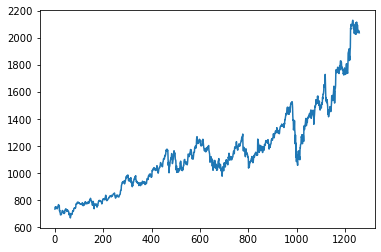

In [20]:
data['Adj Close'].plot()

In [21]:
features = ['Open' , 'High', 'Low','Volume']
feature_tf = data[features]
feature_tf

,Open,High,Low,Volume
0,736.789978,738.989990,732.500000,1301300
1,734.590027,747.250000,728.760010,1903800
2,750.099976,757.880005,748.739990,1782400
3,749.250000,750.849976,740.940002,1718800
4,738.599976,750.340027,737.000000,1576700
...,...,...,...,...
1255,2041.839966,2057.989990,2026.069946,1954800
1256,2051.699951,2072.302002,2039.219971,1367000
1257,2065.370117,2078.209961,2041.555054,1154000
1258,2044.810059,2058.870117,2010.729980,1418900


In [22]:
close_price = data['Adj Close']
close_price = pd.DataFrame(data=close_price.values.ravel(), columns=['Adj Close'],index=data['Date'])
close_price

,Adj Close
Date,
2016-03-28,733.530029
2016-03-29,744.770020
2016-03-30,750.530029
2016-03-31,744.950012
2016-04-01,749.909973
...,...
2021-03-22,2038.589966
2021-03-23,2052.959961
2021-03-24,2045.060059


In [23]:
scaller = MinMaxScaler()
X = scaller.fit_transform(feature_tf)
X = pd.DataFrame(data=X, columns=feature_tf.columns)
X

,Open,High,Low,Volume
0,0.045427,0.045049,0.048031,0.162878
1,0.043908,0.050629,0.045435,0.265691
2,0.054617,0.057809,0.059300,0.244975
3,0.054030,0.053061,0.053888,0.234122
4,0.046676,0.052716,0.051153,0.209873
...,...,...,...,...
1255,0.946536,0.936037,0.945672,0.274393
1256,0.953344,0.945705,0.954798,0.174090
1257,0.962783,0.949695,0.956418,0.137743
1258,0.948587,0.936631,0.935028,0.182946


In [24]:
timesplit = TimeSeriesSplit(n_splits=10)
for train_idx , test_idx in timesplit.split(X):
    X_train , X_test = X[:len(train_idx)],X[len(train_idx):len(train_idx)+len(test_idx)]
    y_train , y_test = close_price[:len(train_idx)].values.ravel() , close_price[len(train_idx):len(train_idx)+len(test_idx)].values.ravel()

In [25]:
X_train

,Open,High,Low,Volume
0,0.045427,0.045049,0.048031,0.162878
1,0.043908,0.050629,0.045435,0.265691
2,0.054617,0.057809,0.059300,0.244975
3,0.054030,0.053061,0.053888,0.234122
4,0.046676,0.052716,0.051153,0.209873
...,...,...,...,...
1141,0.555546,0.550170,0.544944,0.153339
1142,0.547750,0.538146,0.536208,0.238797
1143,0.548302,0.552358,0.556394,0.143510
1144,0.568747,0.570273,0.573298,0.185745


In [26]:
X_test

,Open,High,Low,Volume
1146,0.630221,0.619908,0.624475,0.214020
1147,0.626672,0.618344,0.615683,0.270042
1148,0.604963,0.609847,0.611866,0.203611
1149,0.617875,0.613917,0.624336,0.185642
1150,0.627963,0.618659,0.600049,0.215061
...,...,...,...,...
1255,0.946536,0.936037,0.945672,0.274393
1256,0.953344,0.945705,0.954798,0.174090
1257,0.962783,0.949695,0.956418,0.137743
1258,0.948587,0.936631,0.935028,0.182946


In [27]:
xtrain = np.array(X_train)
xtest = np.array(X_test)
X_train = xtrain.reshape(X_train.shape[0],1,X_train.shape[1])
X_test = xtest.reshape(X_test.shape[0],1,X_test.shape[1])

In [28]:
X_train.shape

(1146, 1, 4)

In [29]:
X_test.shape

(114, 1, 4)

In [30]:
lstm = Sequential()
lstm.add(LSTM(32,input_shape=(1, xtrain.shape[1]),activation='relu',return_sequences=False))
lstm.add(Dense(1))
lstm.compile(optimizer='adam',loss='mean_squared_error')

In [32]:
lstm.fit(X_train,y_train,batch_size=4,epochs=150,verbose=1)

Epoch 1/150
287/287 [==============================] - 2s 2ms/step - loss: 1212372.7500
Epoch 2/150
287/287 [==============================] - 0s 2ms/step - loss: 1184828.3750
Epoch 3/150
287/287 [==============================] - 0s 2ms/step - loss: 1119869.6250
Epoch 4/150
287/287 [==============================] - 0s 2ms/step - loss: 1030868.7500
Epoch 5/150
287/287 [==============================] - 0s 2ms/step - loss: 928621.5625
Epoch 6/150
287/287 [==============================] - 0s 2ms/step - loss: 819316.6250
Epoch 7/150
287/287 [==============================] - 0s 2ms/step - loss: 707745.3750
Epoch 8/150
287/287 [==============================] - 1s 2ms/step - loss: 597652.6250
Epoch 9/150
287/287 [==============================] - 1s 2ms/step - loss: 492524.8438
Epoch 10/150
287/287 [==============================] - 0s 2ms/step - loss: 394975.0000
Epoch 11/150
287/287 [==============================] - 0s 2ms/step - loss: 307032.4062
Epoch 12/150
287/287 [===============

287/287 [==============================] - 1s 2ms/step - loss: 100.0641
Epoch 97/150
287/287 [==============================] - 1s 2ms/step - loss: 99.7884
Epoch 98/150
287/287 [==============================] - 1s 2ms/step - loss: 99.6489
Epoch 99/150
287/287 [==============================] - 1s 2ms/step - loss: 99.5940
Epoch 100/150
287/287 [==============================] - 1s 2ms/step - loss: 100.0592
Epoch 101/150
287/287 [==============================] - 0s 2ms/step - loss: 99.8605
Epoch 102/150
287/287 [==============================] - 1s 2ms/step - loss: 99.6770
Epoch 103/150
287/287 [==============================] - 1s 2ms/step - loss: 100.1236
Epoch 104/150
287/287 [==============================] - 1s 2ms/step - loss: 100.1627
Epoch 105/150
287/287 [==============================] - 0s 2ms/step - loss: 99.4299
Epoch 106/150
287/287 [==============================] - 1s 2ms/step - loss: 99.3055
Epoch 107/150
287/287 [==============================] - 1s 2ms/step - loss: 9

In [34]:
predict = lstm.predict(X_test)

4/4 [==============================] - 0s 3ms/step


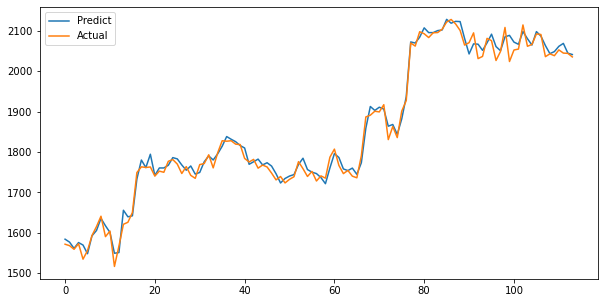

In [35]:
plt.figure(figsize=(10,5))
plt.plot(predict,label='Predict')
plt.plot(y_test,label='Actual')
plt.legend()
plt.show()

In [36]:
r2_score(y_test,predict)

0.9905327751333496

In [37]:
mean_squared_error(y_test,predict)

283.594752744363